# Collaborative Filtering with Neural Nets

In [1]:
# for data manipulation
import numpy as np
import pandas as pd
import os
import pickle
from tqdm import tqdm

# use surprise for collaborative filtering
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable


# plot
import matplotlib.pyplot as plt

## Read in data

In [2]:
game_data_path = "data/neural_net_data/"
files = sorted(os.listdir(game_data_path))

files = ["2012-2013.pkl", "2013-2014.pkl", "2014-2015.pkl", "2015-2016.pkl", "2016-2017.pkl", "2017-2018.pkl"]

X_train = np.zeros(5)

for file in files[:-2]:
    if ".pkl" not in file: continue
    
    with open(game_data_path + file, 'rb') as f:
        print(file)
        if X_train.shape[0] == 5:
            X_train, y_train = pickle.load(f, encoding='latin1')
        else:
            X_add, y_add = pickle.load(f, encoding='latin1')
            print(X_train.shape)
            print(X_add.shape)
            X_train = np.concatenate((X_train, X_add), axis = 0)
            y_train = np.concatenate((y_train, y_add), axis = 0)

with open(game_data_path + files[-2], 'rb') as f:
        print(files[-2])
        X_val, y_val = pickle.load(f, encoding='latin1')
        
with open(game_data_path + files[-1], 'rb') as f:
        print(files[-1])
        X_test, y_test = pickle.load(f, encoding='latin1')

2012-2013.pkl
2013-2014.pkl
(1265, 3, 508)
(1272, 3, 508)
2014-2015.pkl
(2537, 3, 508)
(1263, 3, 508)
2015-2016.pkl
(3800, 3, 508)
(1269, 3, 508)
2016-2017.pkl
2017-2018.pkl


## Clean Data

In [3]:
def clean_data(X, y):
    X = X[y > 0]
    y = y[y > 0]
    
    return X, y

In [4]:
X_train, y_train = clean_data(X_train, y_train)
X_val, y_val = clean_data(X_val, y_val)
X_test, y_test = clean_data(X_test, y_test)

## LSTM Model

In [7]:
#### Specify the model architecture
class LSTMModel(nn.Module):

    def __init__(self, input_dim, hidden_dim, target_size, num_layers, batch_size, time_steps, dropout):
        super(LSTMModel, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.time_steps = time_steps
        self.dropout = dropout
        
        # Initialize LSTM unit
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=False)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2out = nn.Linear(hidden_dim, target_size)
        self.hidden = self.init_hidden()
        
        self.drop = nn.Dropout(dropout)

    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size , hidden_dim)
        return (torch.zeros(self.num_layers, self.time_steps, self.hidden_dim),
                torch.zeros(self.num_layers, self.time_steps, self.hidden_dim))

    def forward(self, input_seq):
        lstm_out, self.hidden = self.lstm(input_seq, self.hidden)
        
        drop_out = self.drop(lstm_out)
        
        pred = self.hidden2out(drop_out)
        
        return pred

In [26]:
## Define the model
model = LSTMModel(input_dim = 508,
                     hidden_dim = 20,
                     target_size = 1,
                     num_layers = 1,
                     batch_size = 10, 
                     time_steps = 3,
                     dropout = 0.2
                 )
                     
loss_function = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.05)#, weight_decay = .01)

In [27]:
losses = []
val_losses = []

for epoch in range(500):
    train_loss = 0
    for i in range(0, len(X_train), model.batch_size):
        if i + model.batch_size >= len(X_train) : continue
        
        #Pytorch accumulates gradients. We need to clear them out before each instance
        model.zero_grad()

        # Also, we need to clear out the hidden state of the LSTM, detaching it from its history on the last instance.
        model.hidden = model.init_hidden()

        # Step 2. Get our inputs ready for the network.
        batch_input = X_train[i : i + model.batch_size] #.reshape((X.shape[1], model.batch_size, X.shape[2]))
        batch = Variable(torch.from_numpy(batch_input)).type(torch.FloatTensor)
                                                    
        targets = Variable(torch.from_numpy(y_train[i : i + model.batch_size])).type(torch.FloatTensor)

        # Step 3. Run our forward pass.
        scores = model(batch)
        scores = scores[:, -1].reshape((model.batch_size)) # we only care about the last output

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = loss_function(scores, targets)
        loss.backward()
        optimizer.step()
        
        #optimizer.zero_grad()   # clear gradients for next train
        
        train_loss += loss.detach().numpy()
        
    ## validation loss
    if (epoch + 1) % 5 == 0:
        print("----------")
        print("Losses after {} iterations:".format(epoch + 1))
        n_batches = len(X_train)/model.batch_size
        print("Train: {}".format(train_loss/n_batches))
        with torch.no_grad():
            batch = Variable(torch.from_numpy(X_val)).type(torch.FloatTensor)
            targets = Variable(torch.from_numpy(y_val)).type(torch.FloatTensor)
            scores = model(batch)
            scores = scores[:, -1].reshape((len(y_val))) # we only care about the last output
            val_loss = loss_function(scores, targets)
            print("Val: {}".format(val_loss))
            val_losses.append(val_loss)
            losses.append(train_loss/n_batches)

----------
Losses after 5 iterations:
Train: 382.46676336779416
Val: 446.8625793457031
----------
Losses after 10 iterations:
Train: 382.1262288723134
Val: 445.3562927246094
----------
Losses after 15 iterations:
Train: 383.43197710113736
Val: 454.57171630859375
----------
Losses after 20 iterations:
Train: 382.7581289376349
Val: 437.90301513671875
----------
Losses after 25 iterations:
Train: 382.673500270955
Val: 458.88543701171875
----------
Losses after 30 iterations:
Train: 383.3652156006302
Val: 438.2406005859375
----------
Losses after 35 iterations:
Train: 383.5922208454214
Val: 452.4633483886719
----------
Losses after 40 iterations:
Train: 383.82683138625316
Val: 451.6240539550781
----------
Losses after 45 iterations:
Train: 383.1243432969053
Val: 443.92333984375
----------
Losses after 50 iterations:
Train: 382.238601003292
Val: 441.4447326660156
----------
Losses after 55 iterations:
Train: 383.1439034435639
Val: 444.24188232421875
----------
Losses after 60 iterations:
Tr

KeyboardInterrupt: 

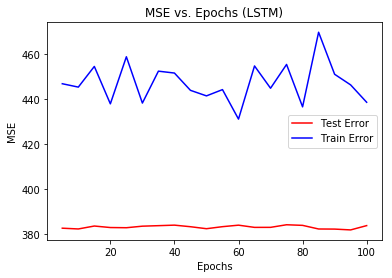

In [30]:
epochs = [i for i in range(5, 101, 5)]
plt.plot(epochs, losses, color="red", label="Test Error")
plt.plot(epochs, val_losses, color="blue", label="Train Error")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.title("MSE vs. Epochs (LSTM)")
plt.savefig("lstm_train.jpg")
plt.show()